In [ ]:
import multiprocessing
import tensorflow as tf

cores = multiprocessing.cpu_count()
tf.config.threading.set_intra_op_parallelism_threads(cores)
tf.config.threading.set_inter_op_parallelism_threads(cores)


from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy("mixed_float16")


print("GPUs:", tf.config.list_physical_devices("GPU"))


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import imgaug.augmenters as iaa


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
DATASET_DIR = "dataset"   # folder inside backend/
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

CLASSES = ["bio-degradable", "non-biodegradable"]


In [3]:
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-15, 15)),
    iaa.Multiply((0.85, 1.15)),
    iaa.GaussianBlur(sigma=0.3),
    iaa.AdditiveGaussianNoise(scale=0.01 * 255),
    iaa.LinearContrast((0.8, 1.2)),
])


In [4]:
class ImgAugSequence(tf.keras.utils.Sequence):
    def __init__(self, keras_generator, augmenter):
        self.generator = keras_generator
        self.augmenter = augmenter

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        images, labels = self.generator[idx]
        # Apply IAG augmentations
        images = self.augmenter(images=images)
        return images, labels

In [5]:
train_gen = ImageDataGenerator(
    validation_split=0.3,
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_keras = train_gen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training"
)

train_data = ImgAugSequence(train_keras, augmenter)  # <--- ImgAug here

val_data = train_gen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation"
)

Found 2696 images belonging to 2 classes.
Found 1154 images belonging to 2 classes.


In [6]:
labels = train_keras.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
cw = {i: weight for i, weight in enumerate(class_weights)}
print("\nClass Weights:", cw)


Class Weights: {0: 1.1423728813559322, 1: 0.8891820580474934}


In [7]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in base_model.layers[:-100]:
    layer.trainable = False

for layer in base_model.layers[-100:]:
    layer.trainable = True

print("\nTrainable layers:", sum([l.trainable for l in base_model.layers]))

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)


2025-11-27 10:38:07.062636: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-27 10:38:07.062670: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-27 10:38:07.062675: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-27 10:38:07.062700: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-27 10:38:07.062715: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Trainable layers: 100


In [8]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,797 (16.07 MB)

 Trainable params: 3,642,358 (13.89 MB)

 Non-trainable params: 571,439 (2.18 MB)

In [9]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    class_weight=cw
)

/Users/suryanshagarwal/Smart-Waste-Segregation-System/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-11-27 10:38:12.603963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 792ms/step - accuracy: 0.6016 - loss: 0.6780 - val_accuracy: 0.7296 - val_loss: 0.5554
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 740ms/step - accuracy: 0.6914 - loss: 0.5859 - val_accuracy: 0.8111 - val_loss: 0.4543
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 745ms/step - accuracy: 0.7263 - loss: 0.5266 - val_accuracy: 0.8432 - val_loss: 0.3972
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 736ms/step - accuracy: 0.7671 - loss: 0.4794 - val_accuracy: 0.8631 - val_loss: 0.3613
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 66s 772ms/step - accuracy: 0.7771 - loss: 0.4640 - val_accuracy: 0.8769 - val_loss: 0.3364
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 67s 789ms/step - accuracy: 0.7852 - loss: 0.4412 - val_accuracy: 0.8813 - val_loss: 0.3176
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 67s 791ms/step - accuracy: 0.7923 - loss: 0.4243 - val_accuracy: 0.8891 - val_loss: 0.2992
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 67s 791ms/step - accuracy: 0.8008 - loss: 0.4090 - val_accuracy: 0.897

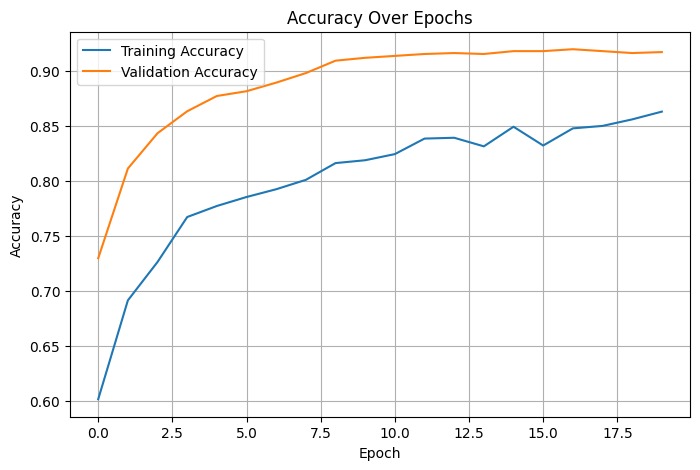

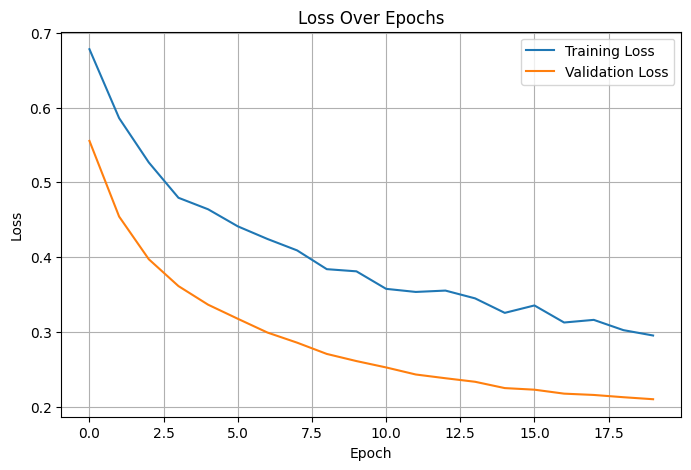

In [12]:
import matplotlib.pyplot as plt

# ----- Accuracy Plot -----
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ----- Loss Plot -----
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# ----- Save .h5 -----
model.save("waste_model.h5")
print("✔ Saved waste_model.h5")

# ----- Save SavedModel -----
model.export("saved_model")
print("✔ Exported SavedModel to saved_model/")


✔ Saved waste_model.h5
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_239')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float16, name=None)
Captures:
  5496465968: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  5496465792: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  5496466672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5496466496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5496466320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5496467200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5496466848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5496467024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5496467904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5496467376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5496468256: TensorSpec(shape=(), dtype=tf.resou